# Implementation of Vanilla GANs model with EBM
Reference: https://arxiv.org/pdf/1406.2661.pdf

In [1]:
import datetime
import os
import sys
import random
import shutil

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torch.utils.data as data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_swiss_roll

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
CUDA_NAME = 'cuda:1'
MODEL_NAME = 'VanillaGAN_EBM'
DATASET_PATH = '~/data'

DEVICE = torch.device(CUDA_NAME if torch.cuda.is_available() else 'cpu')    

# General part

## Energy model

In [171]:
class Sampler:

    def __init__(self, model, input_sampler, input_shape, sample_size, max_len=8192, buffer_update_ratio=0.05):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            input_sampler - G
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        self.model = model
        self.input_sampler = input_sampler
        self.input_shape = input_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.buffer_update_ratio = buffer_update_ratio

        is_training = self.input_sampler.training
        self.input_sampler.eval()
        self.examples = list(p.unsqueeze(0)
                             for p in input_sampler.get_sample(self.sample_size).cpu().data)
        self.input_sampler.train(is_training)

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose (1-buffer_update_ratio) of the batch from the buffer, buffer_update_ratio generate from scratch
        n_new = np.random.binomial(self.sample_size, self.buffer_update_ratio)

        is_training = self.input_sampler.training
        self.input_sampler.eval()
        samp_data = self.input_sampler.get_sample(n_new).cpu()
        self.input_sampler.train(is_training)

        old_data = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_data = torch.cat([samp_data, old_data], dim=0).detach().to(DEVICE)

        # Perform MCMC sampling
        inp_data = Sampler.generate_samples(self.model, inp_data, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_data.to(torch.device('cpu')).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_data

    @staticmethod
    def generate_samples(model, inp_data, steps, step_size, return_data_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_data.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_data.shape, device=inp_data.device)

        # List for storing generations at each step (for later analysis)
        data_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_data.data.add_(noise.data)
            inp_data.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_data = -model(inp_data)
            out_data.sum().backward()
            inp_data.grad.data.clamp_(-0.05, 0.05) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_data.data.add_(-step_size * inp_data.grad.data)
            inp_data.grad.detach_()
            inp_data.grad.zero_()
            inp_data.data.clamp_(min=-1.0, max=1.0)

            if return_data_per_step:
                data_per_step.append(inp_data.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_data_per_step:
            return torch.stack(data_per_step, dim=0)
        else:
            return inp_data

In [179]:
class EnergyModel(nn.Module):

    def __init__(self, energy_model, input_sampler, input_shape, sample_size, buffer_update_ratio=0.05):
        super().__init__()

        self.energy_model = energy_model
        self.sampler = Sampler(energy_model, input_sampler, input_shape, sample_size, buffer_update_ratio=buffer_update_ratio)

    def forward(self, x):
        z = self.energy_model(x)
        return z

## GAN

In [49]:
class Generator(nn.Module):

    def __init__(self, model: nn.Sequential, output_shape):
        super().__init__()
        self.model = model
        self.input_size = model[0].in_features
        self.output_shape = output_shape
        
    def forward(self, x):
        y_ = self.model(x)
        y_ = y_.view(x.size(0), *self.output_shape)
        return y_

    def get_sample(self, batch_size):
        z = torch.randn(batch_size, self.input_size, device=DEVICE)
        z = self(z).view(batch_size, *self.output_shape)
        return z

In [50]:
class Discriminator(nn.Module):

    def __init__(self, model: nn.Sequential):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.model(y_)
        return y_

## Train

In [289]:
def train(D, D_opt,
          G, G_opt, G_input_size, G_delay_fit_steps,
          EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
          gan_criterion, train_loader, epochs,
          use_ebm=True, log_samples_path=None, log_sampler=None, log_step=500):

    D_labels = torch.ones(batch_size, 1, device=DEVICE)
    D_fakes = torch.zeros(batch_size, 1, device=DEVICE)

    if log_samples_path is not None:
        assert log_sampler is not None
        if os.path.exists(log_samples_path):
            shutil.rmtree(log_samples_path)
        os.makedirs(log_samples_path)

    step = 0
    D.train()
    G.train()

    if use_ebm:
        EBM.train()

    for epoch in range(epochs):
        for (batch, _) in train_loader:
            x = batch.to(DEVICE)
            z = G.get_sample(len(batch))

            # Training Discriminator
            x_ = Sampler.generate_samples(EBM, z.data, EBM_steps, EBM_step_size) if use_ebm else x
            x_outputs = D(x_)
            D_x_loss = gan_criterion(x_outputs, D_labels)

            z_outputs = D(z)
            D_z_loss = gan_criterion(z_outputs, D_fakes)
            D_loss = D_x_loss + D_z_loss

            D.zero_grad()
            D_loss.backward()
            D_opt.step()

            if step % G_delay_fit_steps == 0:
                # Training Generator
                z = G.get_sample(len(batch))
                z_outputs = D(z)
                G_loss = gan_criterion(z_outputs, D_labels)

                G.zero_grad()
                G_loss.backward()
                G_opt.step()

            if use_ebm and step % EBM_delay_fit_steps == 0:
                # Training EBM
                noise_ = torch.randn_like(x) * 0.005
                real_ = (x + noise_).clamp_(min=-1.0, max=1.0)

                fake_ = EBM.sampler.sample_new_exmps(EBM_steps, EBM_step_size)

                # Predict energy score for all images
                inp_ = torch.cat([real_, fake_], dim=0)
                real_out, fake_out = EBM(inp_).chunk(2, dim=0)

                # Calculate losses
                reg_loss = EBM_alpha * (real_out ** 2 + fake_out ** 2).mean()
                cdiv_loss = fake_out.mean() - real_out.mean()
                EBM_loss = reg_loss + cdiv_loss

                EBM.zero_grad()
                EBM_loss.backward()
                EBM_opt.step()

            if step % log_step == 0:
                print(f'Epoch: {epoch+1}/{epochs}, Step: {step},'
                      f'\tD Loss: {np.round(D_loss.item(), 5)},\tG Loss: {np.round(G_loss.item(), 5)},'
                      f'\tEBM Loss: {np.round(EBM_loss.item(), 5) if use_ebm else None}')

            if log_samples_path is not None and step % log_step == 0:
                G.eval()
                img = log_sampler(EBM if use_ebm else G)
                imsave(f'{log_samples_path}/{MODEL_NAME}_step{str(step).zfill(3)}.jpg', img, cmap='gray')
                G.train()

            step += 1

## Model generation

In [166]:
def get_models(G_arch, D_arch, data_shape, energy_model=None, sample_size=None, buffer_update_ratio=None):
    
    G = Generator(G_arch, data_shape).to(DEVICE)
    D = Discriminator(D_arch).to(DEVICE)
    if energy_model is None:
        return G, D

    assert isinstance(sample_size, int)
    EBM = EnergyModel(energy_model, G, data_shape, sample_size, buffer_update_ratio).to(DEVICE)
    return G, D, EBM

---

In [78]:
T = 1500
t = 50
n = 10

# Moons

In [17]:
batch_size = 128
data_shape = (2,)

G_input_size = 20
G_output_size = np.prod(data_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [18]:
class MLPModel(nn.Module):

    def __init__(self, input_size, out_dim=1):
        super().__init__()

        self.model = nn.Sequential(
                nn.Linear(input_size, 16),
                nn.SiLU(),
                nn.Linear(16, 32),
                nn.SiLU(),
                nn.Linear(32, 64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.SiLU(),
                nn.Linear(64, 64),
                nn.BatchNorm1d(64),
                nn.SiLU(),
                nn.Linear(64, out_dim)
        )

    def forward(self, x):
        x = self.model(x).squeeze(dim=-1)
        return x

In [19]:
x_train = torch.tensor(make_moons(n_samples=15000, shuffle=False, random_state=seed)[0], dtype=torch.float)
x_test = torch.tensor(make_moons(n_samples=2500, shuffle=False)[0], dtype=torch.float)

mean_ = x_train.mean(0)
x_train -= mean_
x_test -= mean_

norm_ = x_train.max(0).values
x_train /= norm_
x_test /= norm_

train_set = list(zip(x_train, torch.empty(x_train.size(0))))
test_set = list(zip(x_test, torch.empty(x_test.size(0))))

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [20]:
G_arch = nn.Sequential(
    nn.Linear(G_input_size, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(0.2),
    nn.Linear(64, G_output_size),
    nn.Tanh()
)

D_arch = nn.Sequential(
    nn.Linear(D_input_size, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Linear(8, D_output_size),
    nn.Sigmoid()
)

### Vanilla GAN

In [25]:
G, D = get_models(G_arch, D_arch, data_shape)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [26]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      None, None, None, None, None, None,
      gan_criterion, train_loader, epochs, use_ebm=False, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.39828,	G Loss: 0.58401,	EBM Loss: None
Epoch: 9/100, Step: 1000,	D Loss: 0.76943,	G Loss: 1.65597,	EBM Loss: None
Epoch: 18/100, Step: 2000,	D Loss: 0.51585,	G Loss: 2.2689,	EBM Loss: None
Epoch: 26/100, Step: 3000,	D Loss: 0.67554,	G Loss: 3.05547,	EBM Loss: None
Epoch: 35/100, Step: 4000,	D Loss: 0.50842,	G Loss: 4.32464,	EBM Loss: None
Epoch: 43/100, Step: 5000,	D Loss: 0.89506,	G Loss: 2.71559,	EBM Loss: None
Epoch: 52/100, Step: 6000,	D Loss: 0.54763,	G Loss: 3.23861,	EBM Loss: None
Epoch: 60/100, Step: 7000,	D Loss: 0.93169,	G Loss: 2.22728,	EBM Loss: None
Epoch: 69/100, Step: 8000,	D Loss: 0.53379,	G Loss: 2.5265,	EBM Loss: None
Epoch: 77/100, Step: 9000,	D Loss: 0.5887,	G Loss: 3.82885,	EBM Loss: None
Epoch: 86/100, Step: 10000,	D Loss: 0.69593,	G Loss: 3.96999,	EBM Loss: None
Epoch: 95/100, Step: 11000,	D Loss: 0.43521,	G Loss: 4.65017,	EBM Loss: None


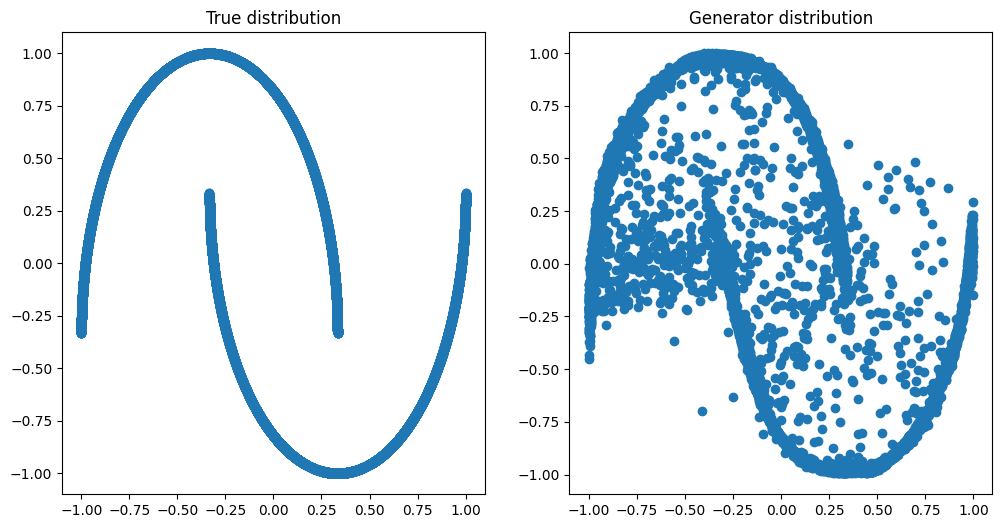

In [29]:
G.eval()
D.eval()

_, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1])
axes[0].set_title('True distribution')

z = G.get_sample(10000).cpu().data

axes[1].scatter(z[:, 0], z[:, 1])
axes[1].set_title('Generator distribution')

plt.show()

### GAN + EBM (steps: 60, step_size: 3)

In [68]:
G, D, EBM = get_models(G_arch, D_arch, data_shape, MLPModel(EBM_input_size), batch_size)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 60
EBM_step_size = 3
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [69]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.38629,	G Loss: 0.69728,	EBM Loss: -0.04644
Epoch: 9/100, Step: 1000,	D Loss: 1.38629,	G Loss: 0.69231,	EBM Loss: -0.62875
Epoch: 18/100, Step: 2000,	D Loss: 1.38629,	G Loss: 0.69253,	EBM Loss: -0.53383
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69312,	EBM Loss: -0.95074
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69311,	EBM Loss: -0.66172
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.69278,	EBM Loss: -0.43912
Epoch: 52/100, Step: 6000,	D Loss: 1.38629,	G Loss: 0.69259,	EBM Loss: -0.27488
Epoch: 60/100, Step: 7000,	D Loss: 1.38629,	G Loss: 0.69224,	EBM Loss: -0.12931
Epoch: 69/100, Step: 8000,	D Loss: 1.38629,	G Loss: 0.6926,	EBM Loss: -0.64377
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.69228,	EBM Loss: -0.9858
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69262,	EBM Loss: -1.3402
Epoch: 95/100, Step: 11000,	D Loss: 1.38631,	G Loss: 0.70061,	EBM Loss: -1.96448


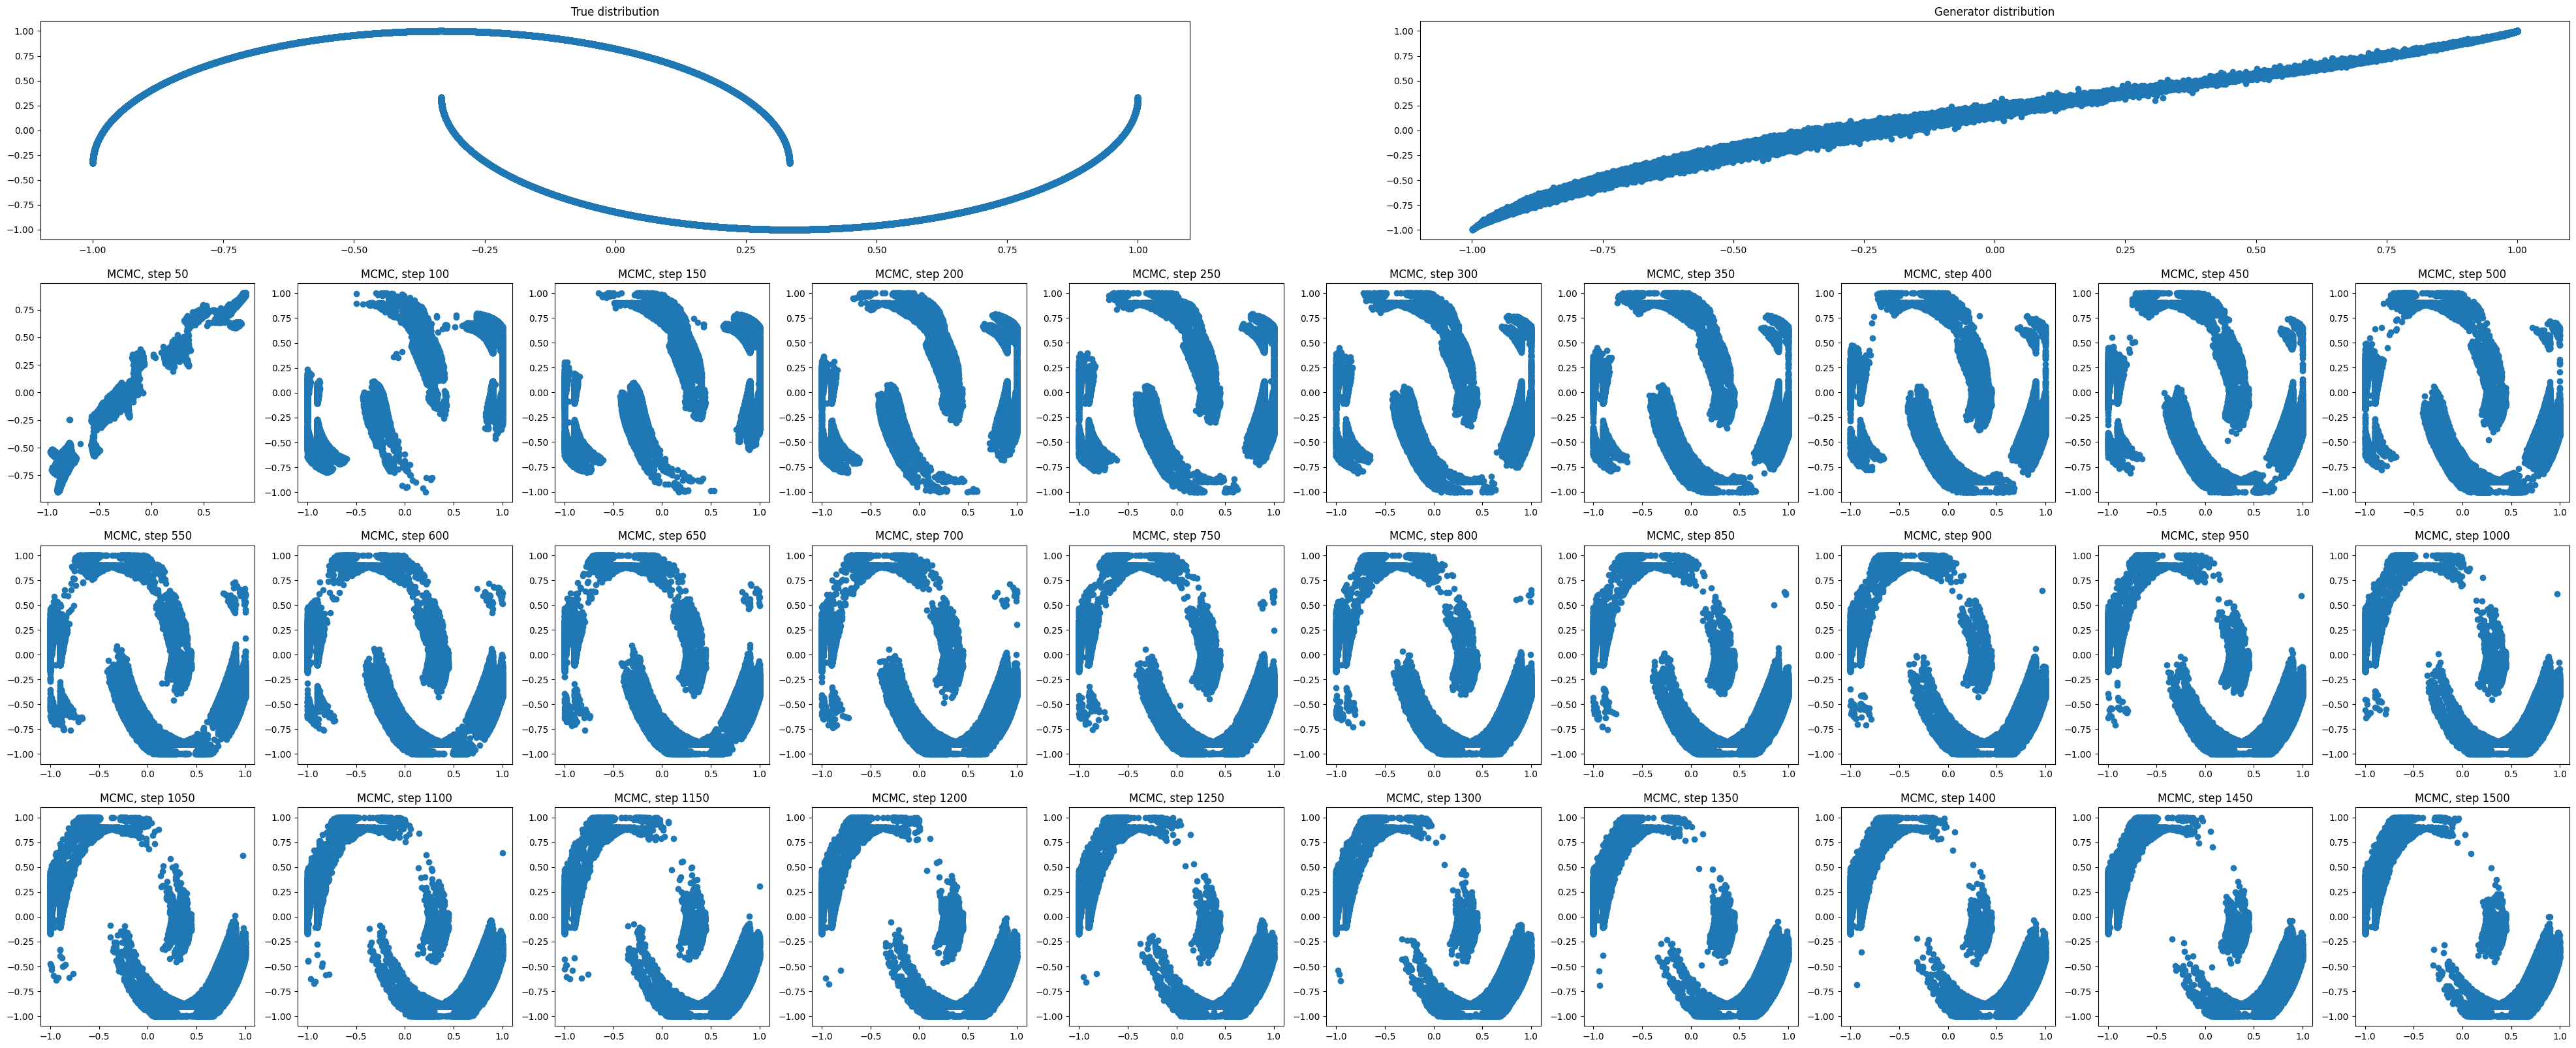

In [81]:
G.eval()
D.eval()
EBM.eval()


z = G.get_sample(50000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 2, return_data_per_step=True)

fig = plt.figure(figsize=(5*n, 5*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

### GAN + EBM (steps: 30, step_size: 5)

In [82]:
G, D, EBM = get_models(G_arch, D_arch, data_shape, MLPModel(EBM_input_size), batch_size)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 30
EBM_step_size = 5
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [83]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.3863,	G Loss: 0.69603,	EBM Loss: -0.3064
Epoch: 9/100, Step: 1000,	D Loss: 1.38629,	G Loss: 0.69296,	EBM Loss: -0.00276
Epoch: 18/100, Step: 2000,	D Loss: 1.38629,	G Loss: 0.69309,	EBM Loss: -1.22792
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69225,	EBM Loss: -2.3179
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69189,	EBM Loss: -2.44494
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.69291,	EBM Loss: -3.1742
Epoch: 52/100, Step: 6000,	D Loss: 1.38629,	G Loss: 0.6931,	EBM Loss: -3.06637
Epoch: 60/100, Step: 7000,	D Loss: 1.3863,	G Loss: 0.69378,	EBM Loss: -3.35225
Epoch: 69/100, Step: 8000,	D Loss: 1.38629,	G Loss: 0.69345,	EBM Loss: -3.63727
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.6926,	EBM Loss: -3.85004
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69284,	EBM Loss: -3.26495
Epoch: 95/100, Step: 11000,	D Loss: 1.38629,	G Loss: 0.69272,	EBM Loss: -3.71579


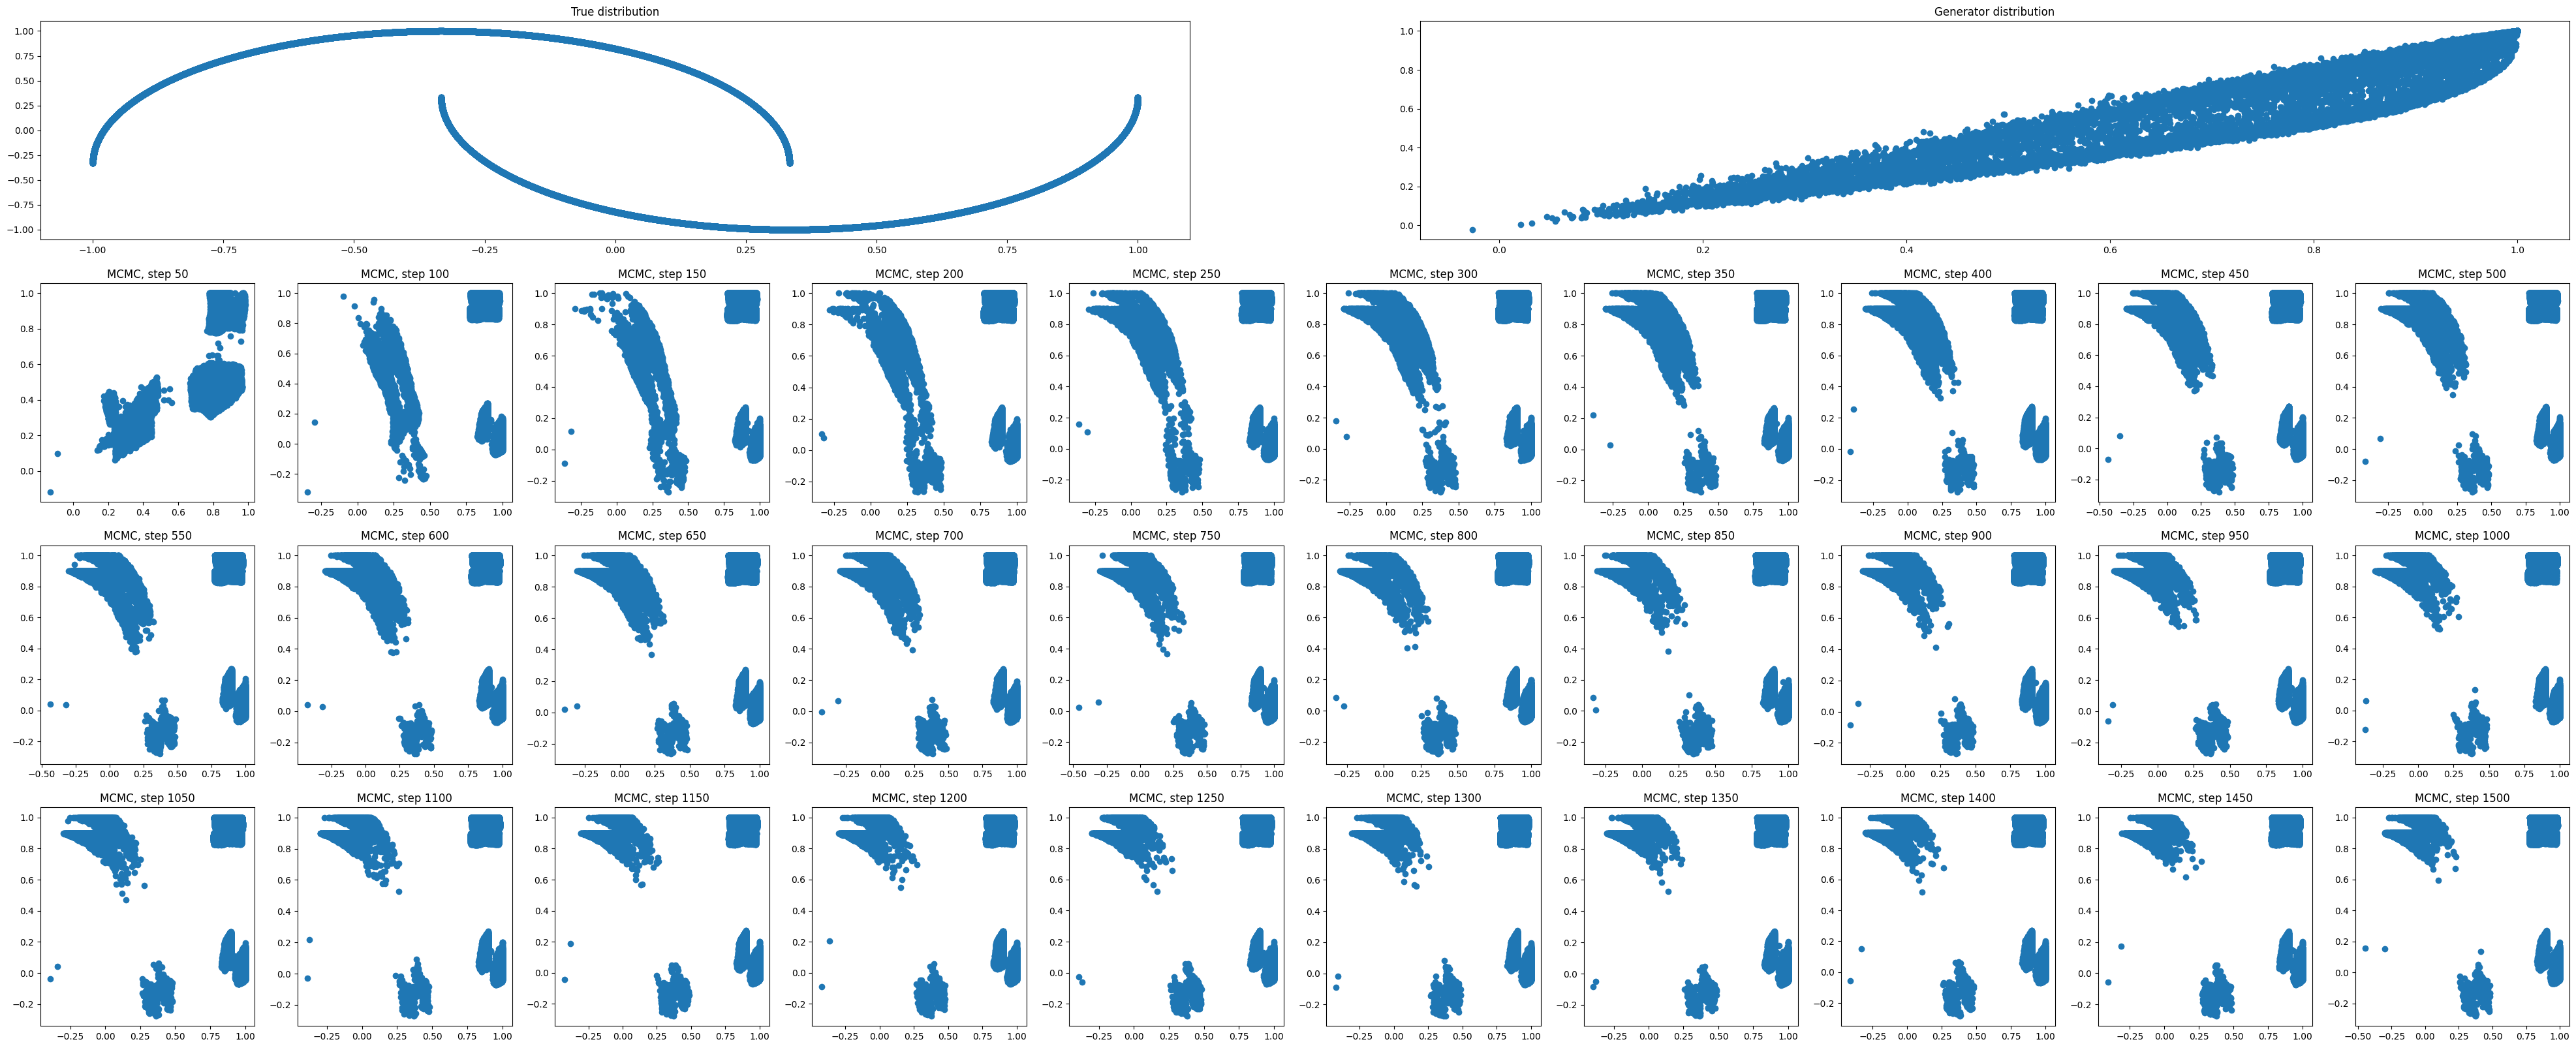

In [84]:
G.eval()
D.eval()
EBM.eval()


z = G.get_sample(50000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 2, return_data_per_step=True)

fig = plt.figure(figsize=(5*n, 5*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

### GAN + EBM (steps: 10, step_size: 10)

In [85]:
G, D, EBM = get_models(G_arch, D_arch, data_shape, MLPModel(EBM_input_size), batch_size)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 10
EBM_step_size = 10
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [86]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.38629,	G Loss: 0.69519,	EBM Loss: -0.2802
Epoch: 9/100, Step: 1000,	D Loss: 1.38629,	G Loss: 0.69257,	EBM Loss: -2.48129
Epoch: 18/100, Step: 2000,	D Loss: 1.38629,	G Loss: 0.69309,	EBM Loss: -2.91462
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69326,	EBM Loss: -3.75499
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69304,	EBM Loss: -3.3299
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.69321,	EBM Loss: -3.98174
Epoch: 52/100, Step: 6000,	D Loss: 1.38629,	G Loss: 0.69304,	EBM Loss: -4.24494
Epoch: 60/100, Step: 7000,	D Loss: 1.38629,	G Loss: 0.69336,	EBM Loss: -3.92035
Epoch: 69/100, Step: 8000,	D Loss: 1.38629,	G Loss: 0.69309,	EBM Loss: -4.1326
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.69321,	EBM Loss: -4.59331
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69332,	EBM Loss: -4.76828
Epoch: 95/100, Step: 11000,	D Loss: 1.38629,	G Loss: 0.6924,	EBM Loss: -4.68714


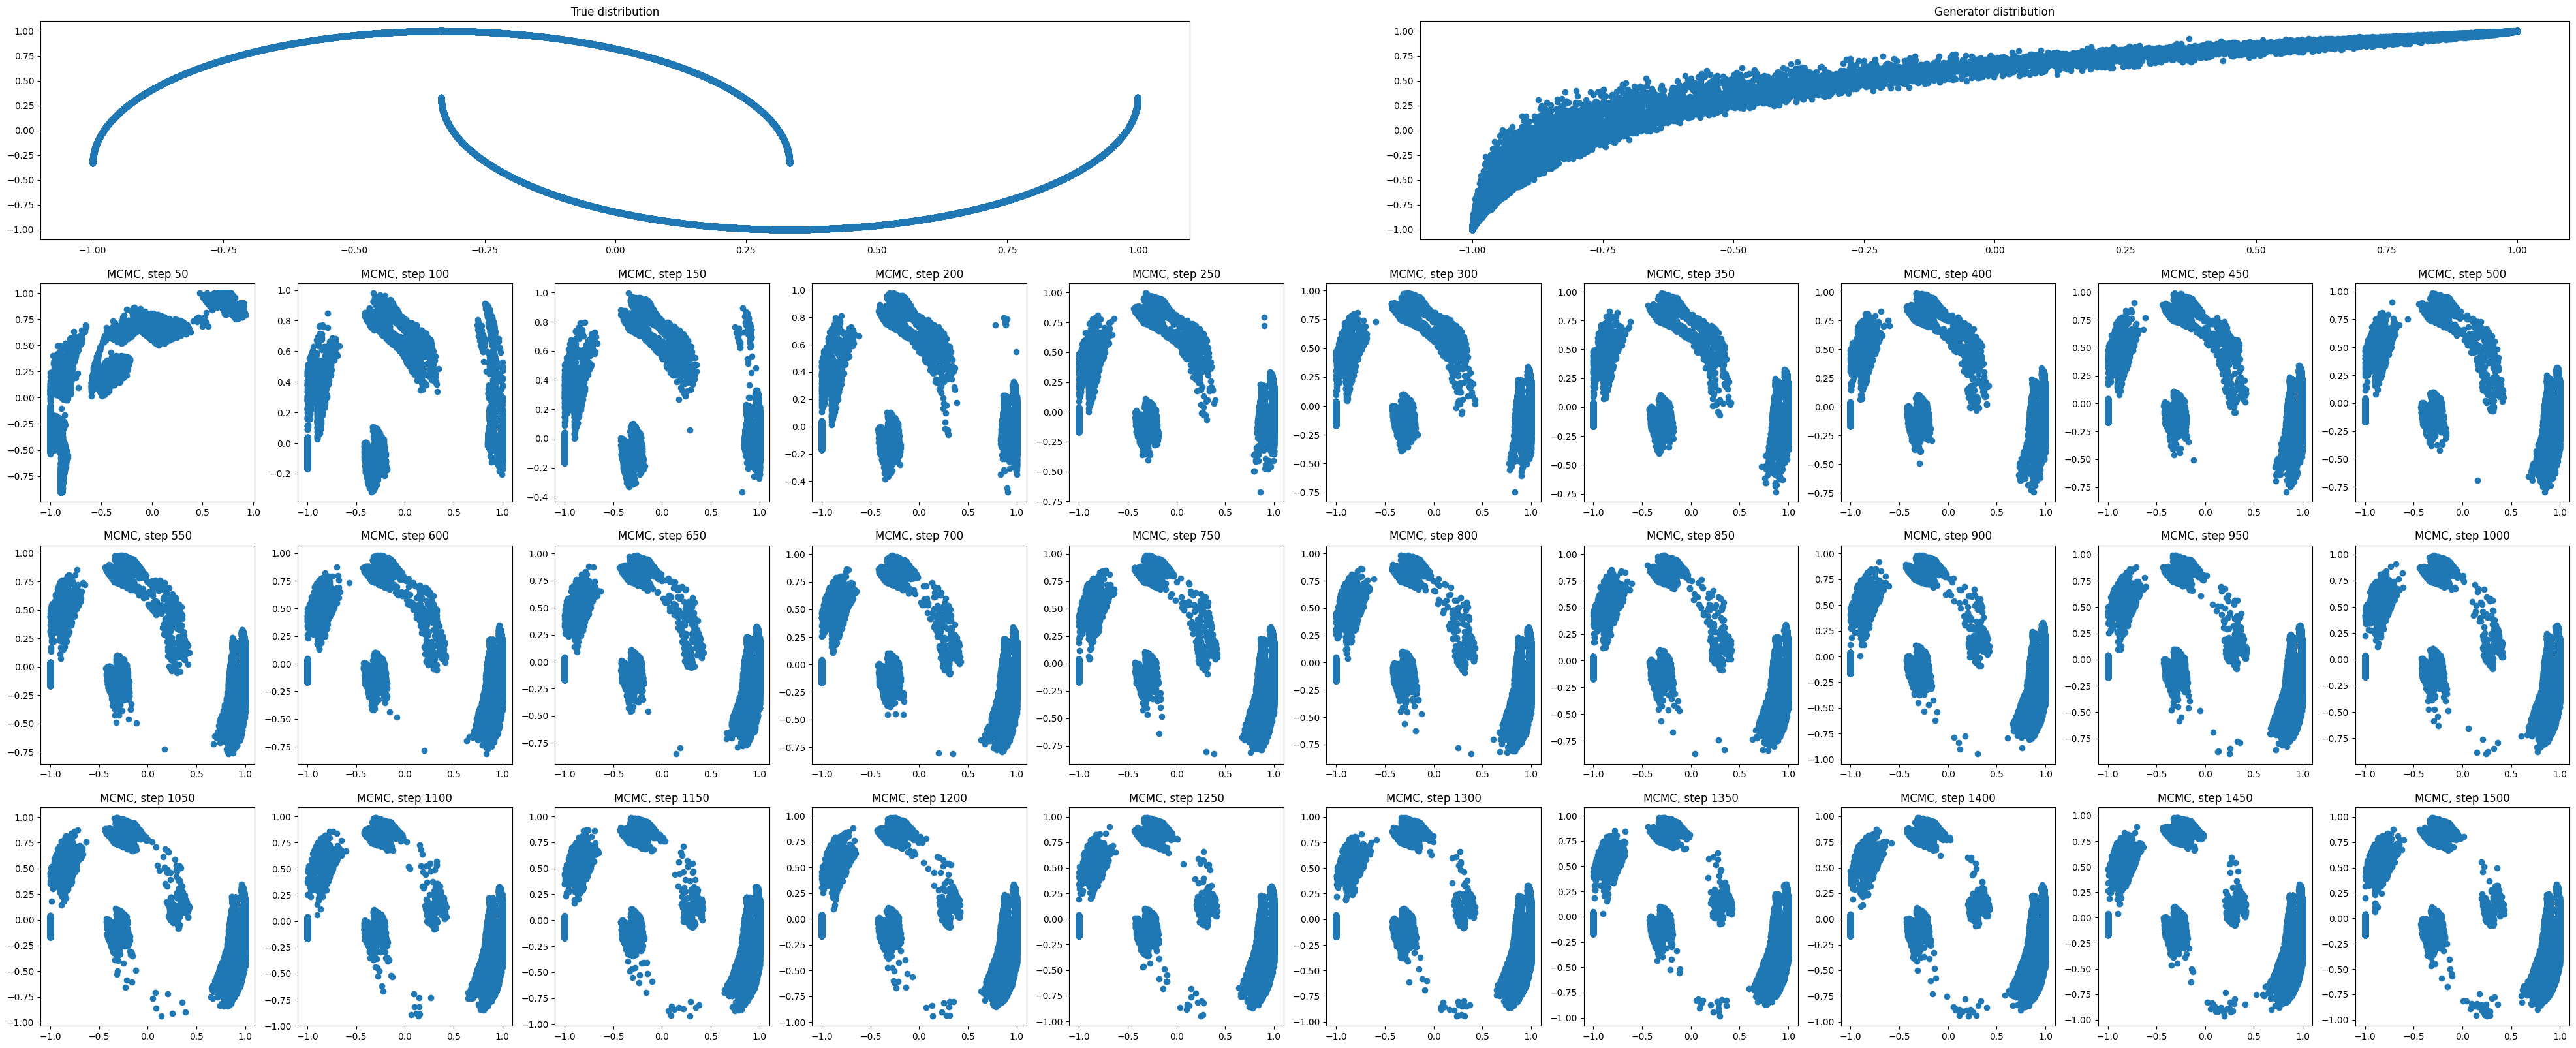

In [87]:
G.eval()
D.eval()
EBM.eval()


z = G.get_sample(50000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 2, return_data_per_step=True)

fig = plt.figure(figsize=(5*n, 5*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

### GAN + EBM (steps: 40, step_size: 5)

In [88]:
G, D, EBM = get_models(G_arch, D_arch, data_shape, MLPModel(EBM_input_size), batch_size)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 40
EBM_step_size = 5
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [89]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.38629,	G Loss: 0.69128,	EBM Loss: 0.22335
Epoch: 9/100, Step: 1000,	D Loss: 1.38629,	G Loss: 0.69309,	EBM Loss: -0.05855
Epoch: 18/100, Step: 2000,	D Loss: 1.38629,	G Loss: 0.6931,	EBM Loss: -0.09841
Epoch: 26/100, Step: 3000,	D Loss: 1.38629,	G Loss: 0.69287,	EBM Loss: -0.92974
Epoch: 35/100, Step: 4000,	D Loss: 1.38629,	G Loss: 0.693,	EBM Loss: -2.00251
Epoch: 43/100, Step: 5000,	D Loss: 1.38629,	G Loss: 0.69301,	EBM Loss: -2.22381
Epoch: 52/100, Step: 6000,	D Loss: 1.38629,	G Loss: 0.69292,	EBM Loss: -2.29474
Epoch: 60/100, Step: 7000,	D Loss: 1.3863,	G Loss: 0.69406,	EBM Loss: -2.65251
Epoch: 69/100, Step: 8000,	D Loss: 1.38629,	G Loss: 0.6933,	EBM Loss: -3.17195
Epoch: 77/100, Step: 9000,	D Loss: 1.38629,	G Loss: 0.6931,	EBM Loss: -3.60121
Epoch: 86/100, Step: 10000,	D Loss: 1.38629,	G Loss: 0.69369,	EBM Loss: -3.56828
Epoch: 95/100, Step: 11000,	D Loss: 1.38629,	G Loss: 0.69299,	EBM Loss: -3.80051


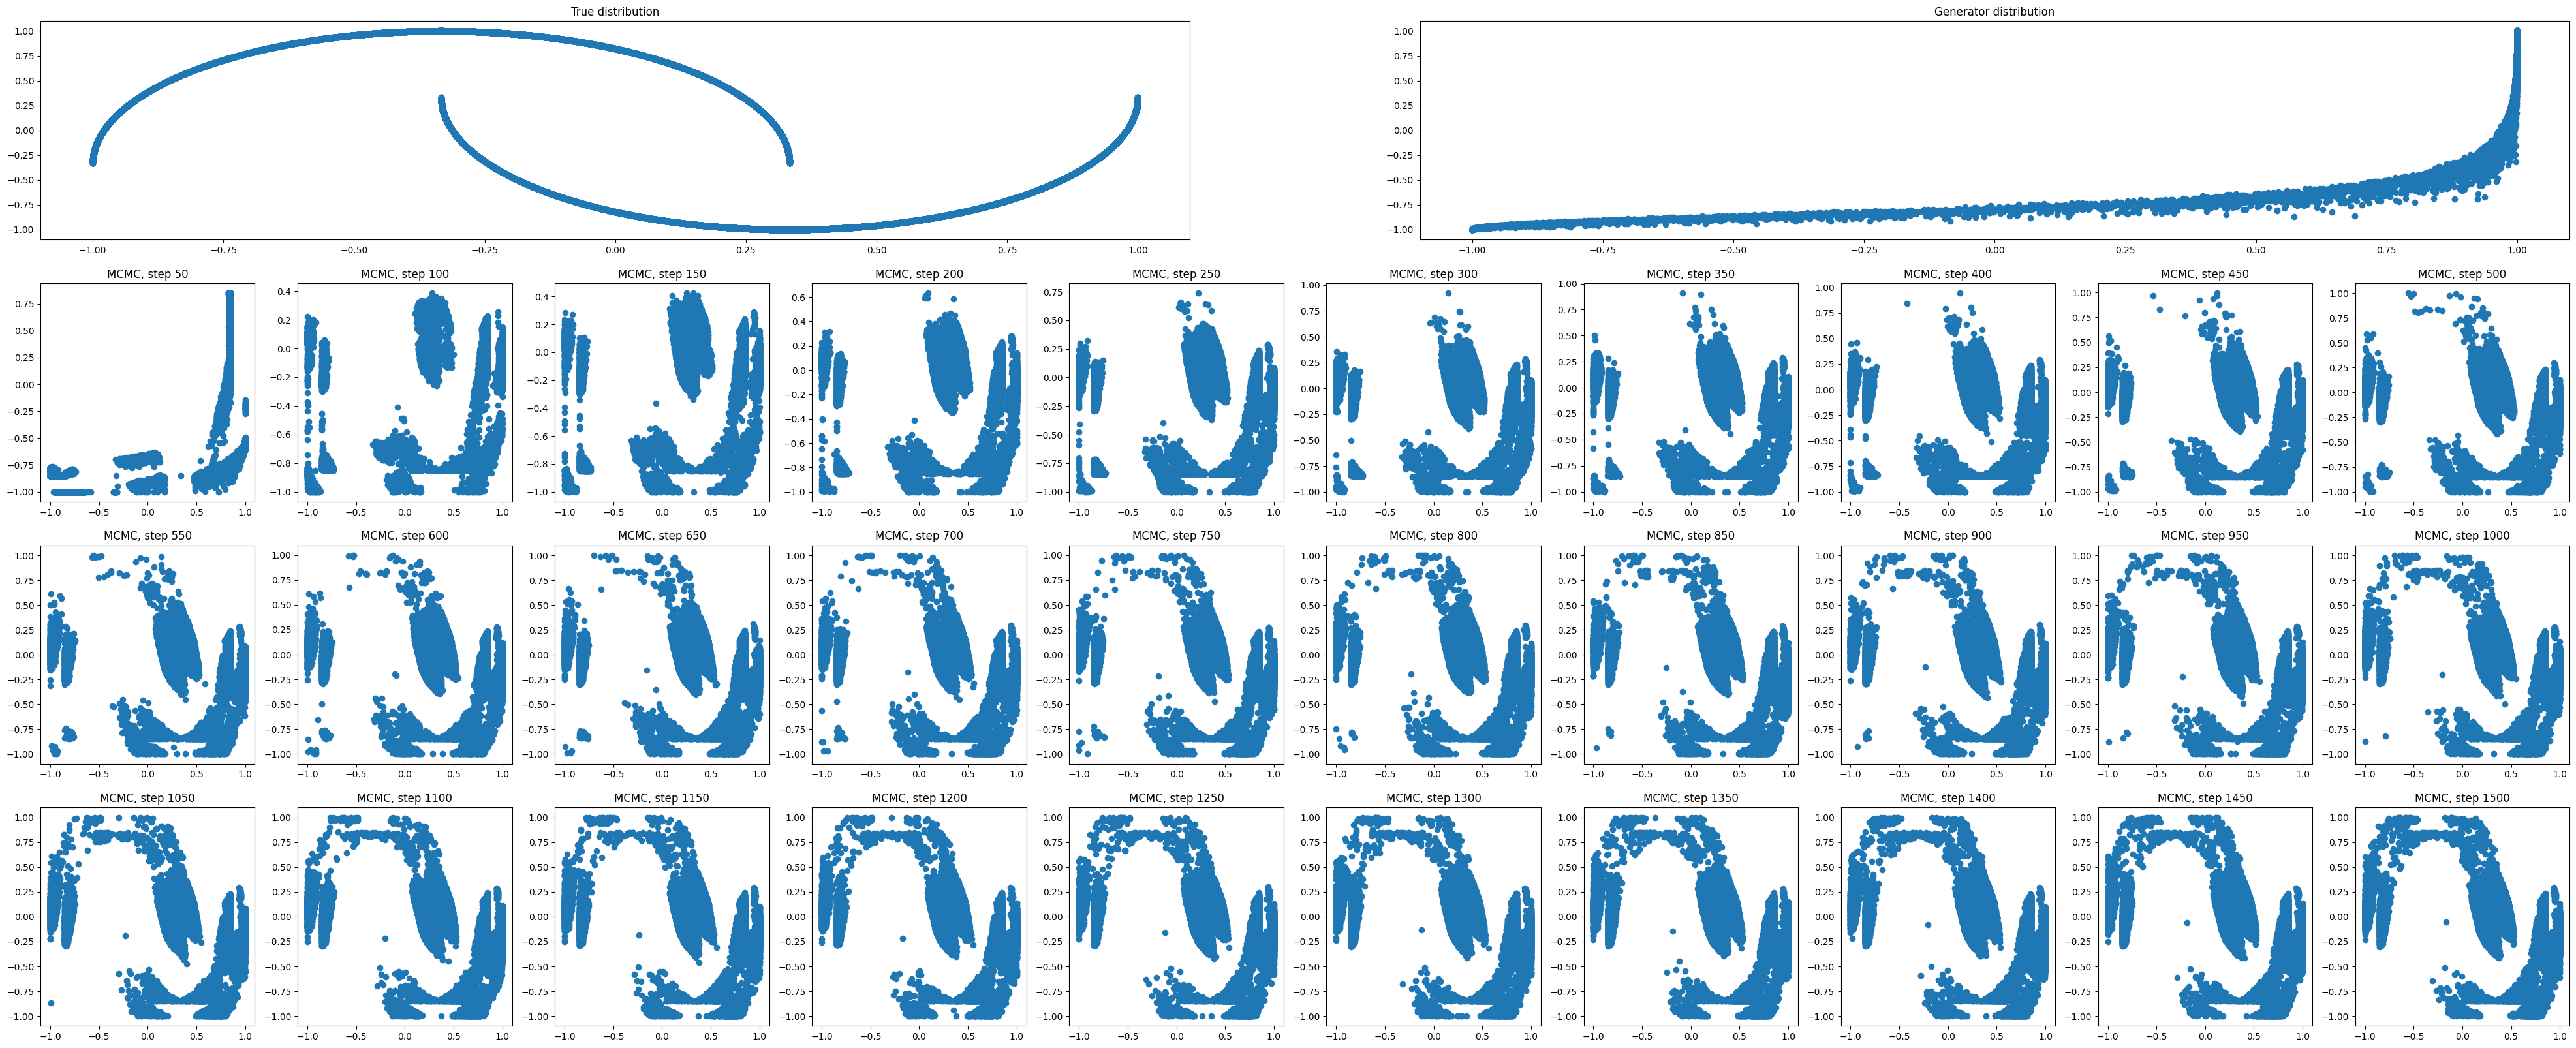

In [96]:
G.eval()
D.eval()
EBM.eval()


z = G.get_sample(50000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 3, return_data_per_step=True)

fig = plt.figure(figsize=(5*n, 5*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

# Swiss roll

In [203]:
batch_size = 128
data_shape = (2,)

G_input_size = 20
G_output_size = np.prod(data_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [204]:
x_train = torch.tensor(make_swiss_roll(n_samples=15000, random_state=seed)[0][:, [0, 2]], dtype=torch.float)
x_test = torch.tensor(make_swiss_roll(n_samples=2500)[0][:, [0, 2]], dtype=torch.float)

mean_ = x_train.mean(0)
x_train -= mean_
x_test -= mean_

norm_ = x_train.max(0).values
x_train /= norm_
x_test /= norm_

train_set = list(zip(x_train, torch.empty(x_train.size(0))))
test_set = list(zip(x_test, torch.empty(x_test.size(0))))

train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

In [207]:
G_arch = nn.Sequential(
    nn.Linear(G_input_size, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(0.2),
    nn.Linear(64, G_output_size),
    nn.Tanh()
)

D_arch = nn.Sequential(
    nn.Linear(D_input_size, 32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 32),
    nn.BatchNorm1d(32),
    nn.LeakyReLU(0.2),
    nn.Linear(32, 16),
    nn.LeakyReLU(0.2),
    nn.Linear(16, 8),
    nn.LeakyReLU(0.2),
    nn.Linear(8, D_output_size),
    nn.Sigmoid()
)

### Vanilla GAN

In [208]:
G, D = get_models(G_arch, D_arch, data_shape)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 150

In [209]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      None, None, None, None, None, None,
      gan_criterion, train_loader, epochs, use_ebm=False, log_step=1000
)

Epoch: 1/150, Step: 0,	D Loss: 1.40924,	G Loss: 0.85684,	EBM Loss: None
Epoch: 9/150, Step: 1000,	D Loss: 0.11794,	G Loss: 4.24294,	EBM Loss: None
Epoch: 18/150, Step: 2000,	D Loss: 0.50438,	G Loss: 3.55849,	EBM Loss: None
Epoch: 26/150, Step: 3000,	D Loss: 0.24839,	G Loss: 3.79697,	EBM Loss: None
Epoch: 35/150, Step: 4000,	D Loss: 0.20403,	G Loss: 4.58407,	EBM Loss: None
Epoch: 43/150, Step: 5000,	D Loss: 0.04029,	G Loss: 5.76256,	EBM Loss: None
Epoch: 52/150, Step: 6000,	D Loss: 0.08946,	G Loss: 4.18595,	EBM Loss: None
Epoch: 60/150, Step: 7000,	D Loss: 0.23106,	G Loss: 4.8441,	EBM Loss: None
Epoch: 69/150, Step: 8000,	D Loss: 0.1632,	G Loss: 5.32821,	EBM Loss: None
Epoch: 77/150, Step: 9000,	D Loss: 0.10308,	G Loss: 3.8873,	EBM Loss: None
Epoch: 86/150, Step: 10000,	D Loss: 0.71207,	G Loss: 2.35943,	EBM Loss: None
Epoch: 95/150, Step: 11000,	D Loss: 0.14482,	G Loss: 4.0233,	EBM Loss: None
Epoch: 103/150, Step: 12000,	D Loss: 0.03893,	G Loss: 6.44125,	EBM Loss: None
Epoch: 112/150, S

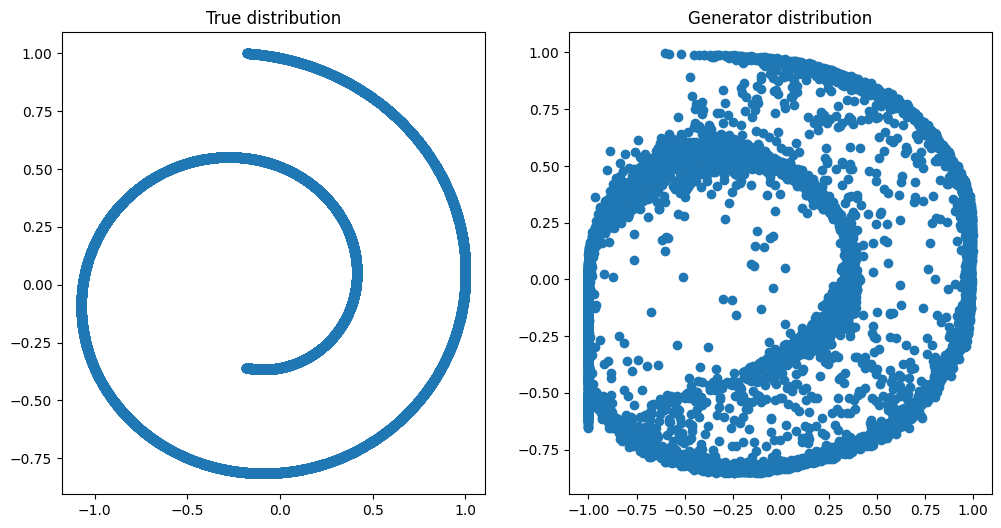

In [210]:
G.eval()
D.eval()

_, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(x_train[:, 0], x_train[:, 1])
axes[0].set_title('True distribution')

z = G.get_sample(10000).cpu().data

axes[1].scatter(z[:, 0], z[:, 1])
axes[1].set_title('Generator distribution')

plt.show()

### GAN + EBM (steps: 60, step_size: 3)

In [122]:
G, D, EBM = get_models(G_arch, D_arch, data_shape, MLPModel(EBM_input_size), batch_size)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 60
EBM_step_size = 3
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [110]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs, log_step=1000
)

Epoch: 9/100, Step: 1000,	D Loss: 1.39257,	G Loss: 0.47444,	EBM Loss: -0.168
Epoch: 18/100, Step: 2000,	D Loss: 1.39149,	G Loss: 0.42811,	EBM Loss: 0.13712
Epoch: 26/100, Step: 3000,	D Loss: 1.38841,	G Loss: 0.49769,	EBM Loss: -0.50352
Epoch: 35/100, Step: 4000,	D Loss: 1.39165,	G Loss: 0.52513,	EBM Loss: -1.04738
Epoch: 43/100, Step: 5000,	D Loss: 1.3899,	G Loss: 0.54612,	EBM Loss: -2.01833
Epoch: 52/100, Step: 6000,	D Loss: 1.38703,	G Loss: 0.61505,	EBM Loss: -2.19431
Epoch: 60/100, Step: 7000,	D Loss: 1.38741,	G Loss: 0.61366,	EBM Loss: -2.3483
Epoch: 69/100, Step: 8000,	D Loss: 1.3878,	G Loss: 0.59437,	EBM Loss: -2.74003
Epoch: 77/100, Step: 9000,	D Loss: 1.3864,	G Loss: 0.62737,	EBM Loss: -3.0821
Epoch: 86/100, Step: 10000,	D Loss: 1.38633,	G Loss: 0.62164,	EBM Loss: -2.95385
Epoch: 95/100, Step: 11000,	D Loss: 1.38636,	G Loss: 0.59227,	EBM Loss: -3.21627


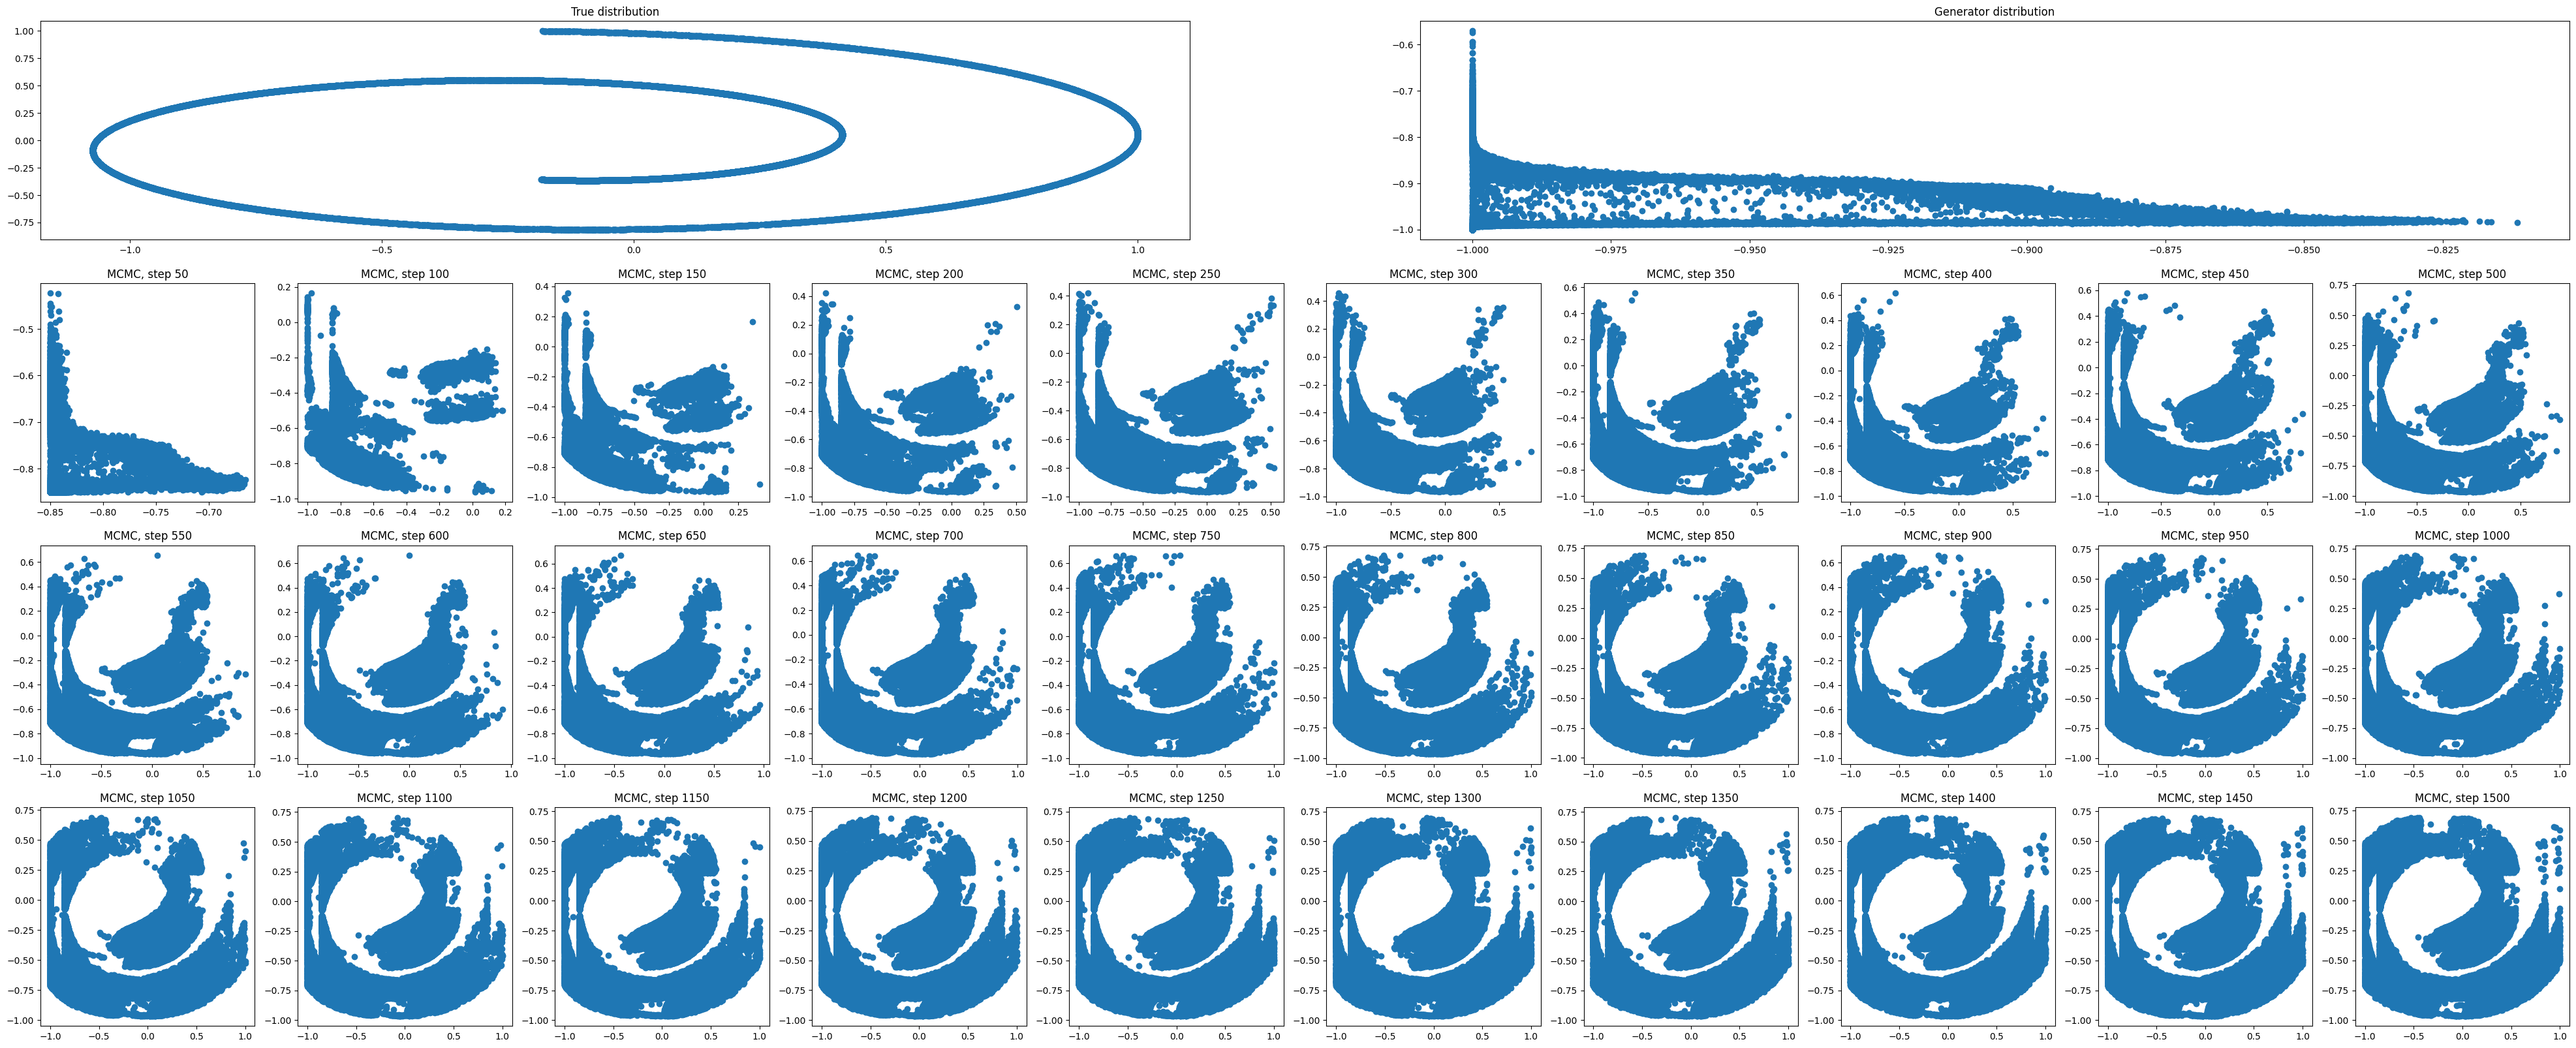

In [117]:
G.eval()
D.eval()
EBM.eval()


z = G.get_sample(50000).cpu().data
xs = Sampler.generate_samples(EBM, z.to(DEVICE), T, 3, return_data_per_step=True)

fig = plt.figure(figsize=(5*n, 5*(1+T//(n*t))))

ax = plt.subplot(1+T//(n*t), 2, 1)
ax.scatter(x_train[:, 0], x_train[:, 1])
ax.set_title('True distribution')

ax = plt.subplot(1+T//(n*t), 2, 2)
ax.scatter(z[:, 0], z[:, 1])
ax.set_title('Generator distribution')

for i, x in enumerate(xs[::t]):
    ax = plt.subplot(1+T//(n*t), n, n+1+i)
    x = x.cpu().detach().numpy()
    ax.scatter(x[:, 0], x[:, 1])
    ax.set_title(f'MCMC, step {t*(i+1)}')

# MNIST

In [333]:
batch_size = 128
img_shape = (1, 28, 28)

G_input_size = 100
G_output_size = np.prod(img_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [334]:
class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, n_channels=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(n_channels, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                nn.SiLU(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                nn.SiLU(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                nn.SiLU(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                nn.SiLU(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                nn.SiLU(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [335]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = datasets.MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = datasets.MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

In [336]:
G_arch = nn.Sequential(
    nn.Linear(G_input_size, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, G_output_size),
    nn.Tanh()
)

D_arch = nn.Sequential(
    nn.Linear(D_input_size, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, D_output_size),
    nn.Sigmoid()
)

In [337]:
def get_sample_image_ebm_mnist(EBM, T=500, step_size=2):
    z = EBM.sampler.input_sampler.get_sample(100).cpu().data
    y_hat = Sampler.generate_samples(EBM, z.to(DEVICE), T, step_size).view(100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28 : (j+1)*28] = np.concatenate([x for x in result[j*10 : (j+1)*10]], axis=-1)
    return img

In [338]:
def get_sample_image_mnist(G):
    result = G.get_sample(100).cpu().data.view(100, 28, 28).numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28 : (j+1)*28] = np.concatenate([x for x in result[j*10 : (j+1)*10]], axis=-1)
    return img

### VanillaGAN

In [339]:
G, D = get_models(G_arch, D_arch, img_shape)

D_opt = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [340]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      None, None, None, None, None, None,
      gan_criterion, train_loader, epochs, use_ebm=False,
      log_samples_path='vanillagan_', log_sampler=get_sample_image_mnist, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.40229,	G Loss: 0.68678,	EBM Loss: None
Epoch: 3/100, Step: 1000,	D Loss: 1.28058,	G Loss: 0.92878,	EBM Loss: None
Epoch: 5/100, Step: 2000,	D Loss: 1.24356,	G Loss: 0.93321,	EBM Loss: None
Epoch: 7/100, Step: 3000,	D Loss: 1.32788,	G Loss: 1.01354,	EBM Loss: None
Epoch: 9/100, Step: 4000,	D Loss: 1.18147,	G Loss: 1.1054,	EBM Loss: None
Epoch: 11/100, Step: 5000,	D Loss: 0.3446,	G Loss: 2.72581,	EBM Loss: None
Epoch: 13/100, Step: 6000,	D Loss: 0.75754,	G Loss: 1.7751,	EBM Loss: None
Epoch: 15/100, Step: 7000,	D Loss: 0.48727,	G Loss: 2.60584,	EBM Loss: None
Epoch: 18/100, Step: 8000,	D Loss: 0.32405,	G Loss: 3.3101,	EBM Loss: None
Epoch: 20/100, Step: 9000,	D Loss: 0.39239,	G Loss: 2.52104,	EBM Loss: None
Epoch: 22/100, Step: 10000,	D Loss: 0.43029,	G Loss: 3.80799,	EBM Loss: None
Epoch: 24/100, Step: 11000,	D Loss: 0.4711,	G Loss: 2.57964,	EBM Loss: None
Epoch: 26/100, Step: 12000,	D Loss: 0.50871,	G Loss: 3.57857,	EBM Loss: None
Epoch: 28/100, Step: 1

### GAN + EBM (steps: 60, step_size: 10)

In [185]:
G, D, EBM = get_models(G_arch, D_arch, img_shape, CNNModel(64), batch_size, buffer_update_ratio=0.5)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 60
EBM_step_size = 10
EBM_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 100

In [186]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs,
      log_samples_path='vanillagan_ebm_mnist', log_sampler=get_sample_image_ebm_mnist, log_step=1000
)

Epoch: 1/100, Step: 0,	D Loss: 1.39441,	G Loss: 4.87147,	EBM Loss: 0.00046
Epoch: 3/100, Step: 1000,	D Loss: 1.38634,	G Loss: 0.65814,	EBM Loss: -0.02597
Epoch: 5/100, Step: 2000,	D Loss: 1.3863,	G Loss: 0.67385,	EBM Loss: 0.00823
Epoch: 7/100, Step: 3000,	D Loss: 1.3863,	G Loss: 0.65815,	EBM Loss: -0.00311
Epoch: 9/100, Step: 4000,	D Loss: 1.38765,	G Loss: 0.61607,	EBM Loss: -0.02843
Epoch: 11/100, Step: 5000,	D Loss: 1.3863,	G Loss: 0.54676,	EBM Loss: -0.0306
Epoch: 13/100, Step: 6000,	D Loss: 1.38631,	G Loss: 0.63819,	EBM Loss: -0.11076
Epoch: 15/100, Step: 7000,	D Loss: 1.3863,	G Loss: 0.60035,	EBM Loss: -0.11264
Epoch: 18/100, Step: 8000,	D Loss: 1.51946,	G Loss: 0.78255,	EBM Loss: 0.00115
Epoch: 20/100, Step: 9000,	D Loss: 1.3863,	G Loss: 0.67122,	EBM Loss: -0.00788
Epoch: 22/100, Step: 10000,	D Loss: 1.3863,	G Loss: 0.66839,	EBM Loss: -0.07229
Epoch: 24/100, Step: 11000,	D Loss: 1.38635,	G Loss: 0.67356,	EBM Loss: 0.01156
Epoch: 26/100, Step: 12000,	D Loss: 1.3863,	G Loss: 0.652

# CIFAR10

In [354]:
batch_size = 128
img_shape = (3, 32, 32)

G_input_size = 200
G_output_size = np.prod(img_shape)

D_input_size = G_output_size
D_output_size = 1

EBM_input_size = G_output_size

In [355]:
class CNNModel(nn.Module):

    def __init__(self, hidden_features=64, out_dim=1, **kwargs):
        super().__init__()
        # We increase the hidden dimension over layers. Here pre-calculated for simplicity.
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        # Series of convolutions and Swish activation functions
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(3, c_hid1, kernel_size=5, stride=2, padding=4), # [18x18]
                nn.SiLU(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [9x9]
                nn.SiLU(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [5x5]
                nn.SiLU(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [3x3]
                nn.SiLU(),
                nn.Flatten(),
                nn.Linear(c_hid3*9, c_hid3),
                nn.SiLU(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [356]:
# Transformations applied on each image => make them a tensor and normalize between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_set = datasets.CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)

# Loading the test set
test_set = datasets.CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True,  num_workers=4, pin_memory=True)
test_loader  = data.DataLoader(test_set,  batch_size=256, shuffle=False, drop_last=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [357]:
G_arch = nn.Sequential(
    nn.Linear(G_input_size, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, G_output_size),
    nn.Tanh()
)

D_arch = nn.Sequential(
    nn.Linear(D_input_size, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 1024),
    nn.BatchNorm1d(1024),
    nn.LeakyReLU(0.2),
    nn.Linear(1024, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, D_output_size),
    nn.Sigmoid()
)

### Vanilla GAN

In [358]:
G, D = get_models(G_arch, D_arch, img_shape)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 1

gan_criterion = nn.BCELoss()
epochs = 80

In [359]:
def get_sample_image_cifar(G):
    z = G.get_sample(96).cpu().data
    img_ = torchvision.utils.make_grid(z)
    img_ = img_ / 2 + 0.5
    return np.transpose(img_.numpy(), (1, 2, 0))


In [360]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      None, None, None, None, None, None,
      gan_criterion, train_loader, epochs, use_ebm=False,
      log_samples_path='vanillagan_cifar', log_sampler=get_sample_image_cifar, log_step=1000
)

Epoch: 1/80, Step: 0,	D Loss: 1.38819,	G Loss: 0.33083,	EBM Loss: None
Epoch: 3/80, Step: 1000,	D Loss: 0.20881,	G Loss: 5.3821,	EBM Loss: None
Epoch: 6/80, Step: 2000,	D Loss: 0.00081,	G Loss: 10.88811,	EBM Loss: None
Epoch: 8/80, Step: 3000,	D Loss: 0.0006,	G Loss: 9.5021,	EBM Loss: None
Epoch: 11/80, Step: 4000,	D Loss: 0.00678,	G Loss: 8.51277,	EBM Loss: None
Epoch: 13/80, Step: 5000,	D Loss: 0.00527,	G Loss: 12.08911,	EBM Loss: None
Epoch: 16/80, Step: 6000,	D Loss: 0.00015,	G Loss: 13.08362,	EBM Loss: None
Epoch: 18/80, Step: 7000,	D Loss: 0.0001,	G Loss: 13.00883,	EBM Loss: None
Epoch: 21/80, Step: 8000,	D Loss: 1e-05,	G Loss: 16.32437,	EBM Loss: None
Epoch: 24/80, Step: 9000,	D Loss: 2e-05,	G Loss: 17.83156,	EBM Loss: None
Epoch: 26/80, Step: 10000,	D Loss: 1e-05,	G Loss: 16.04437,	EBM Loss: None
Epoch: 29/80, Step: 11000,	D Loss: 0.0,	G Loss: 19.49239,	EBM Loss: None
Epoch: 31/80, Step: 12000,	D Loss: 0.0,	G Loss: 15.7923,	EBM Loss: None
Epoch: 34/80, Step: 13000,	D Loss: 0.0,

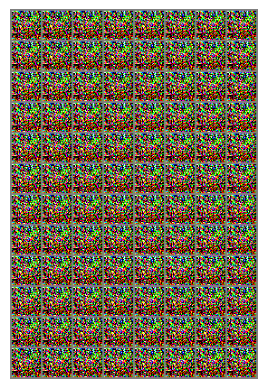

In [361]:
G.eval()
plt.imshow(get_sample_image_cifar(G))
plt.axis('off')
plt.show()

### GAN + EBM (steps: 50, step_size: 10)

In [306]:
G, D, EBM = get_models(G_arch, D_arch, img_shape, CNNModel(64, n_channels=3), batch_size, buffer_update_ratio=0.3)

D_opt = torch.optim.Adam(D.parameters(), lr=0.002, betas=(0.5, 0.999))

G_opt = torch.optim.Adam(G.parameters(), lr=0.002, betas=(0.5, 0.999))
G_delay_fit_steps = 2

EBM_opt = torch.optim.Adam(EBM.parameters(), lr=0.0001)
EBM_alpha = 0.1
EBM_steps = 50
EBM_step_size = 10
EBM_delay_fit_steps = 2

gan_criterion = nn.BCELoss()
epochs = 80

In [307]:
def get_sample_image_ebm_cifar(EBM, T=1500, step_size=2):
    z = EBM.sampler.input_sampler.get_sample(96).data
    y_hat = Sampler.generate_samples(EBM, z.to(DEVICE), T, step_size).cpu().data
    img_ = torchvision.utils.make_grid(y_hat)
    img_ = img_ / 2 + 0.5
    return np.transpose(img_.numpy(), (1, 2, 0))


In [308]:
train(D, D_opt,
      G, G_opt, G_input_size, G_delay_fit_steps,
      EBM, EBM_opt, EBM_alpha, EBM_steps, EBM_step_size, EBM_delay_fit_steps,
      gan_criterion, train_loader, epochs,
      log_samples_path='vanillagan_ebm_cifar', log_sampler=get_sample_image_ebm_cifar, log_step=1000
)

Epoch: 1/80, Step: 0,	D Loss: 1.38651,	G Loss: 0.70728,	EBM Loss: 0.00127
Epoch: 3/80, Step: 1000,	D Loss: 1.38631,	G Loss: 0.69073,	EBM Loss: -0.07376
Epoch: 6/80, Step: 2000,	D Loss: 1.38632,	G Loss: 0.68932,	EBM Loss: -0.01573
Epoch: 8/80, Step: 3000,	D Loss: 1.3863,	G Loss: 0.69213,	EBM Loss: -0.04281
Epoch: 11/80, Step: 4000,	D Loss: 1.38629,	G Loss: 0.69244,	EBM Loss: -0.00186
Epoch: 13/80, Step: 5000,	D Loss: 1.38818,	G Loss: 0.70891,	EBM Loss: 0.01843
Epoch: 16/80, Step: 6000,	D Loss: 1.38632,	G Loss: 0.68225,	EBM Loss: 0.02514
Epoch: 18/80, Step: 7000,	D Loss: 1.3863,	G Loss: 0.68631,	EBM Loss: -0.10023
Epoch: 21/80, Step: 8000,	D Loss: 1.38631,	G Loss: 0.68843,	EBM Loss: -0.00736
Epoch: 24/80, Step: 9000,	D Loss: 1.38631,	G Loss: 0.69033,	EBM Loss: -0.0156
Epoch: 26/80, Step: 10000,	D Loss: 1.3863,	G Loss: 0.69232,	EBM Loss: -0.12791
Epoch: 29/80, Step: 11000,	D Loss: 1.38629,	G Loss: 0.64794,	EBM Loss: 0.02455
Epoch: 31/80, Step: 12000,	D Loss: 1.38632,	G Loss: 0.68841,	EBM 

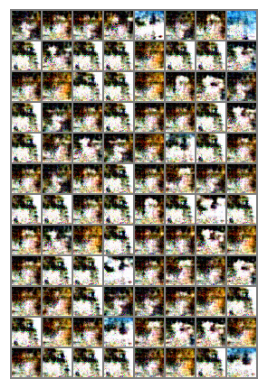

In [315]:
G.eval()
EBM.eval()
plt.imshow(get_sample_image_ebm_cifar(EBM, T=2500))
plt.axis('off')
plt.show()

---